## submit jobs to cluster

In [2]:
import os
from rosemary import jpt_in_notebook, jpt_setup; jpt_setup()
from llm.submit import submit_job, multiline_to_singleline, shell_scripts_template_slurm

first_N = None
log_dir = '/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/scripts/'

test_run = 1
test_run = bool(test_run)

####
model_name = 'all-mpnet-base-v2'; encode_fn_type = 'input'; normalize_embeddings = True

dataset = 'wizardlm'
## 
clustering_fn_list = []
clustering_fn_list += [
    f'cl=kmeans_nc={n_clusters}' for n_clusters in [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
]

# first_N = 10_000
# clustering_fn = f'cl=kmeansminibatch_nc={n_clusters}'
# clustering_fn = f'cl=kmeansminibatch_nc={n_clusters}_bsz=256'


###

cmds = []
for clustering_fn in clustering_fn_list:
    save_dir = (f"/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/scripts/"
                f"clustering/{encode_fn_type+'/' if encode_fn_type!='sft' else ''}{model_name}/"
                f"{dataset+'(N='+str(first_N)+')' if first_N else dataset}/{clustering_fn}")

    cmd = f"""
    python note_pruning_clustering.py \
        --model_name {model_name} \
        --dataset {dataset} \
        --encode_fn_type {encode_fn_type} \
        --clustering_fn {clustering_fn} \
        {'--normalize_embeddings' if normalize_embeddings else ''} \
        {'--first_N '+str(first_N) if first_N else ''} \
        --save_dir {save_dir} \
    """.strip()
    cmd = multiline_to_singleline(cmd)

    shell_scripts = shell_scripts_template_slurm.format(
        conda_env='open-instruct',
        cwd=os.getcwd(),
        cmd=cmd,
        log_dir=log_dir,
        save_dir=save_dir)
    out = submit_job(
        shell_scripts, 
        job_name=f'cluster.{dataset}.{clustering_fn}', 
        nodes=1,
        num_cpus=64,
        cpu_mem=128,
        num_gpus=1,
        gpu_type='v100',
        test_run=test_run,
        job_duration=6,
    )
    print(cmd)
    cmds.append(cmd)
    
print(f'#cmds: {len(cmds)}')


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload



Submiting job with:
{
    "job_name": "cluster.wizardlm.cl=kmeans_nc=100",
    "nodes": 1,
    "num_cpus": 64,
    "cpu_mem": 128,
    "num_gpus": 1,
    "gpu_type": "v100",
    "test_run": true,
    "queue": "x86_6h",
    "num_jobs": 1
}
python note_pruning_clustering.py --model_name all-mpnet-base-v2 --dataset wizardlm --encode_fn_type input --clustering_fn cl=kmeans_nc=100 --normalize_embeddings --save_dir /gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/scripts/clustering/input/all-mpnet-base-v2/wizardlm/cl=kmeans_nc=100

Submiting job with:
{
    "job_name": "cluster.wizardlm.cl=kmeans_nc=200",
    "nodes": 1,
    "num_cpus": 64,
    "cpu_mem": 128,
    "num_gpus": 1,
    "gpu_type": "v100",
    "test_run": true,
    "queue": "x86_6h",
    "num_jobs": 1
}
python note_pruning_clustering.py --model_name all-mpnet-base-v2 --dataset wizardlm --encode_fn_type input --clustering_fn cl=kmeans_nc=200 --normalize_embeddings --save_dir /gpfs/u/home/PTFM/PTFMqngp/

In [3]:
print('\n'.join(['CUDA_VISIBLE_DEVICES=1 '+x for x in cmds]))

CUDA_VISIBLE_DEVICES=1 python note_pruning_clustering.py --model_name all-mpnet-base-v2 --dataset wizardlm --encode_fn_type input --clustering_fn cl=kmeans_nc=100 --normalize_embeddings --save_dir /gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/scripts/clustering/input/all-mpnet-base-v2/wizardlm/cl=kmeans_nc=100
CUDA_VISIBLE_DEVICES=1 python note_pruning_clustering.py --model_name all-mpnet-base-v2 --dataset wizardlm --encode_fn_type input --clustering_fn cl=kmeans_nc=200 --normalize_embeddings --save_dir /gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/scripts/clustering/input/all-mpnet-base-v2/wizardlm/cl=kmeans_nc=200
CUDA_VISIBLE_DEVICES=1 python note_pruning_clustering.py --model_name all-mpnet-base-v2 --dataset wizardlm --encode_fn_type input --clustering_fn cl=kmeans_nc=300 --normalize_embeddings --save_dir /gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/scripts/clustering/input/all-mpnet-base-v2/

## analyze clustering results

In [3]:



save_dir = (f"/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/scripts/"
            f"clustering/{encode_fn_type+'/' if encode_fn_type!='sft' else ''}{model_name}/"
            f"{dataset+'(N='+str(first_N)+')' if first_N else dataset}/{clustering_fn}")


In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from note_pruning_analysis import get_clustering_results, flatten_dict

dataset='wizardlm'
model_name='all-mpnet-base-v2'

clustering_fn_list = [
    f'cl=kmeans_nc={x}' for x in [100, 300, 1000]
]

data = []
for clustering_fn in clustering_fn_list:
    d = get_clustering_results(dataset, model_name, clustering_fn, encode_fn_type='input', return_data=False)
    d = flatten_dict(d['info'])
    d['clustering_fn'] = clustering_fn
    data.append(d)
df = pd.DataFrame(data)
df

,N,dataset,model_name,encode_fn_type,time_elapsed,scores_inertia,scores_silhouette_score_cd,scores_silhouette_score_l2,scores_variance_ratio,scores_davies_bouldin_index,cluster_sizes,clustering_fn
0,143000,dataset,all-mpnet-base-v2,input,123.734123,103517.156250,0.048404,0.026555,363.530728,4.018901,"[4681, 3258, 3179, 2231, 2194, 2103, 2098, 199...",cl=kmeans_nc=100
1,143000,dataset,all-mpnet-base-v2,input,286.909671,95027.453125,0.052221,0.028893,173.574461,3.806885,"[1573, 1132, 1078, 1067, 1051, 1015, 899, 863,...",cl=kmeans_nc=300
2,143000,dataset,all-mpnet-base-v2,input,888.920390,86033.328125,0.034909,0.020458,71.960102,3.682080,"[400, 358, 343, 338, 332, 324, 303, 302, 294, ...",cl=kmeans_nc=1000


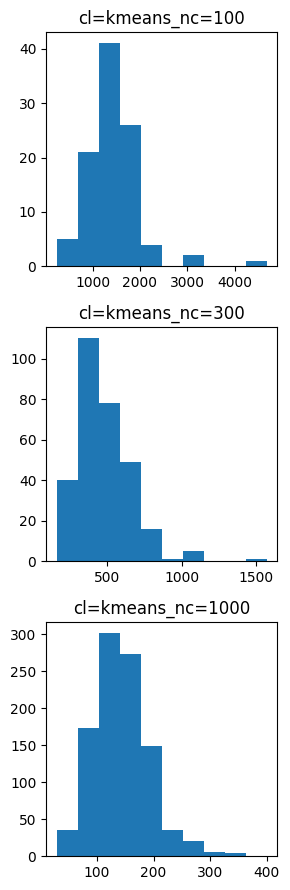

In [8]:
ys_list = df['cluster_sizes'].tolist()
N = len(ys_list)

fig, axs = plt.subplots(N,1,figsize=(3,3*N), sharex=False)
for i in range(N):
    ys = ys_list[i]
    ax = axs[i]
    ax.hist(ys)
    ax.set_title(df.iloc[i]['clustering_fn'])
fig.tight_layout()

## clustering code base


In [1]:
from rosemary import jpt_parse_args, jpt_setup, jpt_in_notebook; jpt_setup()

if jpt_in_notebook():
    import os
    print(os.environ['CUDA_VISIBLE_DEVICES'].split(','))
    os.environ['CUDA_VISIBLE_DEVICES'] = os.environ['CUDA_VISIBLE_DEVICES'].split(',')[0] 
    # '0,1,2,3,4,5'
    print(os.environ['CUDA_VISIBLE_DEVICES'])
# !nvidia-smi

/gpfs/u/scratch/PTFM/PTFMqngp/minoconda3_x86/envs/open-instruct/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


['0', '1']
0


In [2]:
import re
import argparse
import json
import pickle
import string
import time
import matplotlib.pyplot as plt

import numpy as np
import scipy
from sentence_transformers import SentenceTransformer
from sentence_transformers.util import cos_sim
from sklearn.cluster import KMeans, AgglomerativeClustering
import torch
from tqdm import tqdm
import pandas as pd

from datasets import load_dataset
from transformers import AutoTokenizer, AutoModel

from torch.utils.data import DataLoader
import torch
import torch.nn.functional as F

import time
from note_pruning_analysis import (
    get_lm_output,
    get_dataset,
)
from note_pruning_clustering import (
    pairwise_cosine_distance,
    clustering_sort_by_cluster_size,
    clustering_algorithm_scores,
    clustering_dist_to_centroids,
    clustering_knn_withincluster,
    clustering_run,
    clustering_compute_and_save_results,
)


In [3]:
model_name = 'all-mpnet-base-v2'

dataset = 'wizardlm'
encode_fn_type = 'input'
first_N = 10_000

n_clusters = 50
clustering_fn = f'cl=kmeans_nc={n_clusters}'
# clustering_fn = f'cl=kmeansminibatch_nc={n_clusters}'
# clustering_fn = f'cl=kmeansminibatch_nc={n_clusters}_bsz=256'

In [4]:
save_dir = os.path.join('clustering', encode_fn_type, model_name, dataset, clustering_fn)
os.makedirs(save_dir, exist_ok=True)
save_dir

'clustering/input/all-mpnet-base-v2/wizardlm/cl=kmeans_nc=50'

In [89]:

ds = get_dataset(dataset, processed=True)
if encode_fn_type == 'input':
    def get_user_prompt_fn(example):
        example['text'] = example['messages'][0]['content']
        return example
    ds = ds.map(get_user_prompt_fn, num_proc=16)

ds

Dataset({
    features: ['dataset', 'id', 'messages', 'text'],
    num_rows: 143000
})

In [6]:
d = get_lm_output(dataset, 
                  model_name, 
                  encode_fn_type=encode_fn_type,
                  return_text_embedding=True,)
X = d['text_embedding']
X = X / np.linalg.norm(X, axis=-1, keepdims=True)

if first_N:
    ds = ds.select(range(first_N))
    X = X[:first_N]

In [7]:

info = {}
info['N'] = len(X)
info['dataset'] = 'dataset'
info['model_name'] = model_name
info['encode_fn_type'] = encode_fn_type

t0 = time.time()
Y, C, clustering_model = clustering_run(clustering_fn, X)
info['time_elapsed'] = time.time()-t0
info['scores'] = {}
info['scores'].update({'inertia': clustering_model.inertia_})
info['scores'].update(clustering_algorithm_scores(X, Y))
info['cluster_sizes'] = np.unique(Y, return_counts=True)[1].tolist()

with open(os.path.join(save_dir, 'info.json'), 'w') as f:
    json.dump(info, f, ensure_ascii=False, indent=4)

clustering_compute_and_save_results(X, Y, C, ds=ds, save_dir=save_dir)


Initialization complete
Iteration 0, inertia 12931.5419921875.
Iteration 1, inertia 7934.09326171875.
Iteration 2, inertia 7803.97607421875.
Iteration 3, inertia 7746.90087890625.
Iteration 4, inertia 7716.8564453125.
Iteration 5, inertia 7699.97998046875.
Iteration 6, inertia 7687.66845703125.
Iteration 7, inertia 7676.8759765625.
Iteration 8, inertia 7665.97412109375.
Iteration 9, inertia 7656.21435546875.
Iteration 10, inertia 7647.60009765625.
Iteration 11, inertia 7639.765625.
Iteration 12, inertia 7632.6123046875.
Iteration 13, inertia 7625.7197265625.
Iteration 14, inertia 7619.81396484375.
Iteration 15, inertia 7615.34326171875.
Iteration 16, inertia 7611.671875.
Iteration 17, inertia 7608.85400390625.
Iteration 18, inertia 7606.25439453125.
Iteration 19, inertia 7604.7060546875.
Iteration 20, inertia 7603.83251953125.
Iteration 21, inertia 7603.06787109375.
Iteration 22, inertia 7602.568359375.
Iteration 23, inertia 7602.1328125.
Iteration 24, inertia 7601.810546875.
Iteration

In [8]:

data = {
    'data_ind': np.arange(len(Y)),
    'cluster_assignment': Y,
    'cent_dist_l2': clustering_dist_to_centroids(X, Y, C, device='cuda', dist='l2'),
    'cent_dist_cd': clustering_dist_to_centroids(X, Y, C, device='cuda', dist='cd'),
}
for dist in ['l2', 'cd']:
    I, D = clustering_knn_withincluster(X, Y, device='cuda', dist=dist)
    data.update({f'knn_inds_{dist}': I, 
                 f'knn_dist_{dist}': D,})

df = pd.DataFrame(data)

cent_dist_l2_vs_cd_spearmanr = float(scipy.stats.spearmanr(
    df['cent_dist_l2'].to_numpy(), df['cent_dist_cd'].to_numpy()).statistic)
print(f'cent_dist_l2_vs_cd_spearmanr: {cent_dist_l2_vs_cd_spearmanr}')

with open(os.path.join(save_dir, 'data.pkl'), 'wb') as f:
    output = {'df': df, 'C': C, 'Y': Y}
    pickle.dump(output, f)


## visualize text near cluster centers

cluster_sizes = np.unique(Y, return_counts=True)[1].tolist()

for dist in ['l2', 'cd']:
    df_topk = df.sort_values(by=['cluster_assignment', f'cent_dist_{dist}']) \
                .groupby('cluster_assignment') \
                .head(20)
    output = []
    for i, count in enumerate(cluster_sizes):
        dfi = df_topk[df_topk['cluster_assignment']==i]
        output.append(
            {
                'cluster': i,
                'cluster_size': count,
                'examples': [{'text': ds[ind]['text'], 
                              f'cent_dist_{dist}': x, 
                              'ind': ind}
                     for ind, x in zip(dfi['data_ind'].to_list(),
                                       dfi[f'cent_dist_{dist}'].to_list())]
            }
        )

    with open(os.path.join(save_dir, f"text_clusterwise_topk_dist={dist}.json"), 'w') as f:
        json.dump(output, f, ensure_ascii=False, indent=4)

## visualize text with similar embeddings

n_examples_per_cluster = 5
k_neighbors = 2

for dist in ['l2', 'cd']:

    output = []
    for i, count in enumerate(cluster_sizes):
        dfi = df[df['cluster_assignment']==i]
        dfi = dfi.sample(n=min(n_examples_per_cluster, len(dfi)), random_state=0)
        ID = dfi.apply(lambda row: ([row['data_ind']]+row[f'knn_inds_{dist}'],
                                     [0]+row[f'knn_dist_{dist}'],), axis=1).tolist()
        output += [
            {
                'cluster': i,
                'cluster_size': count,
                'examples': [{'text': ds[ind]['text'], 
                              f'knn_dist_{dist}': v,
                              f'ind': ind}
                            for ind, v in zip(inds[:1+k_neighbors], 
                                              vals[:1+k_neighbors])]
            } for inds, vals in ID
        ]

    with open(os.path.join(save_dir, f'text_knn_clusterwise_dist={dist}.json'), 'w') as f:
        json.dump(output, f, ensure_ascii=False, indent=4)

        


cent_dist_l2_vs_cd_spearmanr: 0.9985226094568997


In [94]:
## visualize examples with very close neighbors

closest_pct = .2
num_examples = 100
k_neighbors = 2

for dist in ['l2', 'cd']:

    sort_by_1nn_dist = lambda x: x.apply(lambda y: y[0])
    dfs = df.sort_values(by=f'knn_dist_{dist}', key=sort_by_1nn_dist) \
            .head(int(closest_pct*len(df))) \
            .sample(n=num_examples, random_state=0) \
            .sort_values(by=f'knn_dist_{dist}', key=sort_by_1nn_dist)


    ID = [([a]+b,[0]+c) for a, b, c in zip(dfs['data_ind'].tolist(),
                                           dfs[f'knn_inds_{dist}'].tolist(),
                                           dfs[f'knn_dist_{dist}'].tolist(),)]
    output = [
        {
            'cluster': i,
            'cluster_size': count,
            'examples': [{'text': ds[ind]['text'], 
                          f'knn_dist_{dist}': v,
                          f'ind': ind}
                        for ind, v in zip(inds[:1+k_neighbors], 
                                          vals[:1+k_neighbors])]
        } for inds, vals in ID
    ]

    with open(os.path.join(save_dir, f'text_knn_closest_dist={dist}.json'), 'w') as f:
        json.dump(output, f, ensure_ascii=False, indent=4)

In [95]:
dfs

,data_ind,cluster_assignment,cent_dist_l2,cent_dist_cd,knn_inds_l2,knn_dist_l2,knn_inds_cd,knn_dist_cd
4536,4536,7,1.000071,0.760793,"[89, 2803, 3287, 1350, 1505]","[0.0, 0.0, 0.0, 0.0, 0.0]","[89, 2803, 3287, 1350, 1505]","[-1.1920928955078125e-07, -1.1920928955078125e..."
7310,7310,7,1.000071,0.760793,"[89, 2803, 3287, 1350, 1505]","[0.0, 0.0, 0.0, 0.0, 0.0]","[89, 2803, 3287, 1350, 1505]","[-1.1920928955078125e-07, -1.1920928955078125e..."
6175,6175,5,0.796551,0.369728,"[499, 5588, 7017, 7609, 5917]","[0.2066289484500885, 0.7831690311431885, 0.949...","[499, 5588, 7017, 7609, 5917]","[0.021347761154174805, 0.30667686462402344, 0...."
725,725,8,0.849404,0.469049,"[9248, 6371, 8719, 8922, 2250]","[0.2766825258731842, 0.8403964042663574, 0.964...","[9248, 6371, 8719, 8922, 2250]","[0.03827667236328125, 0.35313302278518677, 0.4..."
7522,7522,5,0.840589,0.449458,"[5744, 8338, 310, 8762, 8948]","[0.2803276479244232, 0.9385234117507935, 0.994...","[5744, 8338, 310, 8762, 8948]","[0.03929167985916138, 0.440413236618042, 0.494..."
...,...,...,...,...,...,...,...,...
2936,2936,24,0.810307,0.411995,"[5036, 1371, 9889, 1738, 2821]","[0.8351047039031982, 0.8412138819694519, 0.867...","[5036, 1371, 9889, 1738, 2821]","[0.3486999273300171, 0.3538203835487366, 0.375..."
3285,3285,26,0.860851,0.490832,"[9697, 8269, 9780, 470, 5723]","[0.8352123498916626, 0.9995755553245544, 1.021...","[9697, 8269, 9780, 470, 5723]","[0.34878993034362793, 0.499575674533844, 0.521..."
1052,1052,37,0.858596,0.486267,"[4582, 4695, 3539, 2790, 5203]","[0.8354029655456543, 0.9705139994621277, 0.974...","[4582, 4695, 3539, 2790, 5203]","[0.34894901514053345, 0.4709486961364746, 0.47..."
3042,3042,23,0.868528,0.504265,"[8837, 9902, 737, 8363, 8954]","[0.836006760597229, 0.9602696895599365, 0.9794...","[8837, 9902, 737, 8363, 8954]","[0.3494536280632019, 0.461059033870697, 0.4796..."


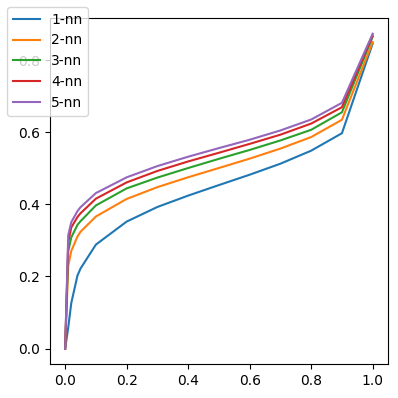

In [96]:
# torch.quantile(knn_dist, .5, dim=0)

xs = [0,0.01,0.02,0.02,0.04,.05,.1,.2,.3,.4,.5,.6,.7,.8,.9,1]

fig, ax = plt.subplots(1,1,figsize=(4,4))
for i in range(5):
    ys = [np.quantile(knn_dist[:,i], x) for x in xs]
    ax.plot(xs, ys, label=f'{i+1}-nn')
fig.legend(loc='upper left')
fig.tight_layout()


In [57]:
i = 0
mask = (Y==i)
inds_global = torch.nonzero(torch.from_numpy(mask)).squeeze()
Xi = torch.from_numpy(X).float()[mask]
Di = torch.cdist(Xi, Xi, p=2.0)
Di.fill_diagonal_(0.0)
Di_triu = torch.triu(Di, diagonal=1)
Di_triu[torch.tril(torch.ones_like(Di_triu)).bool()] = float('inf')
Di_triu

tensor([[   inf, 1.3892, 1.3279,  ..., 1.3155, 1.4240, 1.4222],
        [   inf,    inf, 1.3686,  ..., 1.4866, 1.4049, 1.3846],
        [   inf,    inf,    inf,  ..., 1.3637, 1.3751, 1.4527],
        ...,
        [   inf,    inf,    inf,  ...,    inf, 1.3593, 1.3440],
        [   inf,    inf,    inf,  ...,    inf,    inf, 1.3505],
        [   inf,    inf,    inf,  ...,    inf,    inf,    inf]])

In [67]:
torch.min(Di_triu, dim=0)

torch.return_types.min(
values=tensor([   inf, 1.3892, 1.3279, 1.2994, 1.2486, 1.3175, 1.2814, 1.3226, 1.2882,
        1.2900, 1.2482, 1.3065, 1.2324, 1.3022, 1.3466, 1.1492, 1.2866, 1.3251,
        1.3026, 1.2537, 1.2648, 1.2793, 1.3347, 1.2060, 1.2651, 1.1974, 1.2255,
        1.2843, 1.3241, 1.2574, 1.2823, 1.1570, 1.3319, 1.3016, 1.2917, 1.1928,
        1.2567, 1.3372, 1.1778, 1.2842, 1.2109, 1.1688, 1.2824, 1.1951, 1.3299,
        1.2538, 1.2318, 1.2927, 1.2506, 1.1225, 1.1988, 1.2344, 1.2910, 1.2702,
        1.1304, 1.2559, 1.2827, 1.2695, 1.3106, 1.1999, 1.2539, 1.2239, 1.1796,
        1.1447, 1.2035, 1.2351, 1.2681, 1.1653, 1.1881, 1.1956, 1.2472, 1.1635,
        1.2327, 1.2031, 1.1229, 1.2345, 1.2378, 1.3095, 1.1787, 1.2275, 1.1448,
        1.2104, 1.1779, 1.2777, 1.2119, 1.2615, 1.1484, 1.2092, 1.2104, 1.1450,
        1.1023, 1.1774, 1.2444, 1.1210, 1.2661, 1.2858, 1.0442, 1.2608, 1.0617,
        1.0237, 1.2270, 1.2223, 1.1859, 1.0927, 1.2146, 1.0802, 1.2333, 1.2876,
        1

In [74]:
M, inds_min = torch.min(Di_triu, dim=0)

eps = .5
mask_discard = M <= eps
inds_discard = inds_global[torch.nonzero(mask_discard)].squeeze().tolist()
inds_discard_closest = inds_global[inds_min[mask_discard]].squeeze().tolist()


In [78]:
for i, j in zip(inds_discard, inds_discard_closest):
    print(json.dumps({
        'i': i,
        'j': j,
        'text_i': ds[i]['text'],
        'text_j': ds[j]['text']
    }, indent=4))

{
    "i": 5448,
    "j": 4713,
    "text_i": "How can I improve my game theory optimal (GTO) strategy for playing poker, including but not limited to implementing mixed strategies, understanding range construction and utilizing blockers to gain an advantage?",
    "text_j": "How can I optimize my poker gameplay using GTO tactics by employing advanced strategies such as implementing mixed strategies, understanding range construction, and utilizing blockers to gain a strategic advantage in multiple steps?"
}
{
    "i": 7695,
    "j": 7358,
    "text_i": "In a Rails application that uses Mongoid as an object-document mapper, suppose we have a property model that has a many-to-many association with amenities, and an amenity model that has a one-to-many association with sources. Given a specific amenity ID, how can we construct a query that returns all properties associated with that amenity? Please provide a detailed, multi-step explanation along with code examples.",
    "text_j": "In th

In [75]:
for ind in inds:
    print(ds[ind]['text'])




['How can I improve my game theory optimal (GTO) strategy for playing poker, including but not limited to implementing mixed strategies, understanding range construction and utilizing blockers to gain an advantage?']
['In a Rails application that uses Mongoid as an object-document mapper, suppose we have a property model that has a many-to-many association with amenities, and an amenity model that has a one-to-many association with sources. Given a specific amenity ID, how can we construct a query that returns all properties associated with that amenity? Please provide a detailed, multi-step explanation along with code examples.']
['What distinguishes fine-tuning from embeddings in GPT models? Can you provide specific examples of when each method would be more beneficial?']
['What is the SSH command in Google Cloud with CentOS 7 that enables timed or condition-based rebooting? Specifically, how can one initiate system reboot if CPU usage surpasses 90%, memory usage goes beyond 80%, or 

In [25]:
eps = .1
dist = 'cd'

def in_eps_ball_fn(row):
    
    
    return True

df.apply(in_eps_ball_fn, axis=1)

0       True
1       True
2       True
3       True
4       True
        ... 
9995    True
9996    True
9997    True
9998    True
9999    True
Length: 10000, dtype: bool